In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from PIL import Image
import numpy as np
import torch
import cv2
import os
import matplotlib.pyplot as plt

from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
import numpy as np
torch.set_printoptions(linewidth=120)
import cv2
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
torch.set_printoptions(linewidth=120)
from shutil import copy
plt.ion()   # interactive mode

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score

In [0]:
root = "/content/drive/My Drive/mini/segmentation/ead2020_semantic_segmentation"

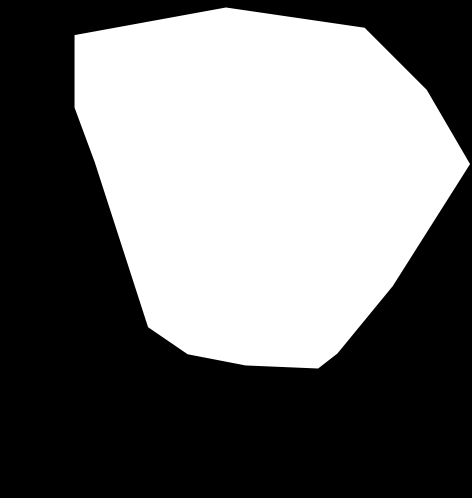

In [4]:
Image.open(root+'/masks_ead2020/EAD2020_semantic_00000.tif')

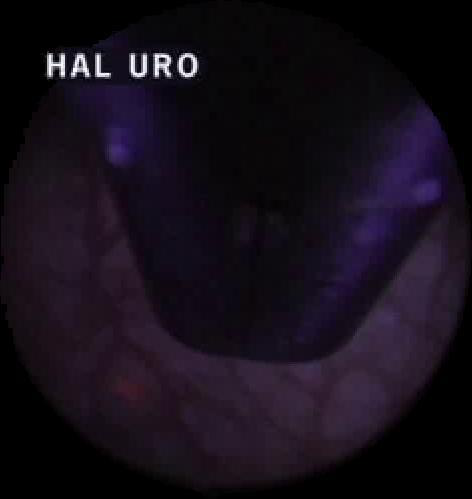

In [5]:
Image.open(root+'/images_ead2020/EAD2020_semantic_00000.jpg')

In [6]:
in_trans = transforms.Compose([
                                 transforms.Resize((400,400),interpolation=2),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

out_trans = transforms.Compose([
                                transforms.Resize((400,400),interpolation=2),
                                transforms.ToTensor(),
                                #transforms.Normalize(mean=[0.485],std=[0.229])
])
class EndoData(Dataset):
    def __init__(self,in_dir,out_dir):
        self.in_dir = in_dir
        self.out_dir = out_dir
        os.chdir(in_dir)
        self.in_list = os.listdir()
        self.in_list.sort()
        os.chdir(out_dir)
        self.out_list = os.listdir()
        self.out_list.sort()
        print(self.in_list == self.out_list)
        
    def __len__(self):
        return len(self.in_list)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        os.chdir(self.in_dir)
        in_name = self.in_list[idx]
        in_image = Image.open(in_name)
        in_image = in_trans(in_image)

        os.chdir(self.out_dir)
        out_name = self.out_list[idx]
        out_image = Image.open(out_name)
        # print(out_image.size)
        out_image = out_trans(out_image)
        sample = {'in_image': in_image.cuda(), 
                  'out_image': out_image.cuda()
                  }
        return sample
endocvdataset = EndoData('/content/drive/My Drive/mini/augment/output','/content/drive/My Drive/mini/augment/output2')

False


In [7]:
my_iter=iter(endocvdataset)
batch = next(iter(endocvdataset))

KeyboardInterrupt: ignored

In [0]:
batch['out_image'].shape

torch.Size([1, 400, 400])

In [0]:
endocvdataset.in_list[10]

'EAD2020_semantic_00002.jpg_4.png'

In [0]:
endocvdataset.out_list[10]

'EAD2020_semantic_00002.tif_2.tif'

# UNet Architecture

In [0]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [0]:
""" Full assembly of the parts to form the complete network """

import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [0]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = torch.flatten(y_true)
    y_pred_f = torch.flatten(y_pred)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)



In [0]:
os.mkdir('/content/drive/My Drive/mini/models/deeplab/')

FileExistsError: ignored

In [0]:
fcn = UNet(3,1).cuda()
# fcn = torch.load('/content/drive/My Drive/mini/models/unet1/84.pt')
#fcn = torchvision.models.segmentation.fcn_resnet101(pretrained=False, progress=True, num_classes=1).cuda()
batch_size = 2
train_loader = torch.utils.data.DataLoader(endocvdataset,batch_size)
optimizer = optim.Adam(fcn.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

epoch = 40
no_of_epoch = 80
for epoch in range(0, no_of_epoch):
    total_loss = 0
    total_correct = 0
    counter = 0
    f1 = 0
    for batch in train_loader:
        input_imgs,output_imgs = batch['in_image'],batch['out_image']
        preds = fcn(input_imgs.float())

     #training summarized
        #print(preds.shape,output_imgs)
        
        y = output_imgs
        y_pred = preds
        #print("\npred:",torch.max(y_pred))
        # print(y_pred[0], y)
        loss = criterion(y_pred, y.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        counter+=1
        #if((counter/batch_size)%2 == 0):
          #print(counter/batch_size,end='')


        #f1+=f1_score(y, y_pred) #f1_score(preds.float().flatten().detach().cpu(),output_imgs.float().flatten().detach().cpu())
    torch.save(fcn,'/content/drive/My Drive/mini/models/unet1/sub'+str(epoch)+'.pt')
        
#         total_correct+=get_num_correct(preds,labels)
    print("epoch:",epoch,"total_loss:",total_loss)#, "f1:",f1)
    print("----------------------------")
    fi = open('/content/drive/My Drive/mini/trainviewer.txt', "a+")
    fi.write(str(epoch)+","+str(total_loss)+"\n")
    # logfile=open("/content/drive/My Drive/mapdata_processed/model/test12/LOG.txt", "a+")
    # logfile.write("epoch:"+str(epoch)+" total_loss:"+str(total_loss)+"\n")
    # logfile.close()

epoch: 0 total_loss: 170.63513144804165
----------------------------
epoch: 1 total_loss: 153.12886097258888
----------------------------
epoch: 2 total_loss: 140.24978839908727
----------------------------
epoch: 3 total_loss: 132.8133646172937
----------------------------
epoch: 4 total_loss: 120.74620891851373
----------------------------
epoch: 5 total_loss: 115.66606010613032
----------------------------
epoch: 6 total_loss: 105.00782899046317
----------------------------
epoch: 7 total_loss: 100.53003238374367
----------------------------
epoch: 8 total_loss: 91.6858682971797
----------------------------
epoch: 9 total_loss: 88.45747635135194
----------------------------
epoch: 10 total_loss: 85.64144757232862
----------------------------
epoch: 11 total_loss: 82.41759946936509
----------------------------
epoch: 12 total_loss: 75.92475144134369
----------------------------
epoch: 13 total_loss: 72.98300028103404
----------------------------
epoch: 14 total_loss: 70.7790291600977

In [0]:
  import torchvision
  ##################### batch - 47
from PIL import Image
fcn = torch.load('/content/drive/My Drive/mini/models/unet1/sub29.pt')

in_trans = transforms.Compose([
                                 transforms.Resize((400,400),interpolation=2),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [0]:
fcn = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False, progress=True, num_classes=1).cuda()

(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 

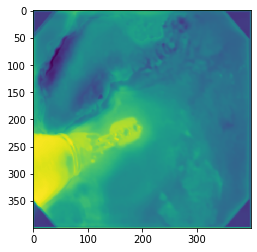

In [13]:
import os
for i in os.listdir('/content/drive/My Drive/mini/segmentation/ead2020_semantic_segmentation/images_ead2020'):
  root = '/content/drive/My Drive/mini/segmentation/ead2020_semantic_segmentation/images_ead2020'
  test_img = Image.open(root+'/'+i)
  test_img = in_trans(test_img)
  output = fcn(test_img.cuda().unsqueeze(0).float())
  img = output.detach().cpu().numpy()
  oimg = np.moveaxis(img[0], -1, 0)
  img = np.moveaxis(oimg, -1, 0)
  print(img.shape)
  plt.imshow(img[:,:,0])
  img = cv2.resize(img,(608,608))
  img = img*255
  cv2.imwrite('/content/drive/My Drive/mini/results/'+i,img)

In [0]:
import numpy as np
from sklearn.metrics import confusion_matrix
batch_size=2;
gt_mask = torch.utils.data.DataLoader('/content/drive/My Drive/mini/endocv/ead2020_semantic_segmentation/ead2020_semantic_segmentation/masks_ead2020',batch_size)
pred = torch.utils.data.DataLoader('/content/drive/My Drive/mini/results',batch_size)

# for batch in train_loader:
#       input_imgs,output_imgs = batch['in_image'],batch['out_image']
#       preds = fcn(input_imgs.float())
#      #training summarized
#         #print(preds.shape,output_imgs)
#         y_true= output_imgs
#         y_pred = preds
# class RunningConfusionMatrix():
#     """Running Confusion Matrix class that enables computation of confusion matrix
#     on the go and has methods to compute such accuracy metrics as Mean Intersection over
#     Union MIOU.
    
#     Attributes
#     ----------
#     labels : list[int]
#         List that contains int values that represent classes.
#     overall_confusion_matrix : sklean.confusion_matrix object
#         Container of the sum of all confusion matrices. Used to compute MIOU at the end.
#     ignore_label : int
#         A label representing parts that should be ignored during
#         computation of metrics
        
#     """
    
#     y_true_f = torch.flatten(y_true)
#     y_pred_f = torch.flatten(y_pred)
#     def __init__(self, labels, ignore_label=255):
        
#         self.labels = labels
#         self.ignore_label = ignore_label
#         self.overall_confusion_matrix = None
        
#     def update_matrix(self, ground_truth, prediction):
#         """Updates overall confusion matrix statistics.
#         If you are working with 2D data, just .flatten() it before running this
#         function.

#         Parameters
#         ----------
#         groundtruth : array, shape = [n_samples]
#             An array with groundtruth values
#         prediction : array, shape = [n_samples]
#             An array with predictions
#         """
        
#         # Mask-out value is ignored by default in the sklearn
#         # read sources to see how that was handled
#         # But sometimes all the elements in the groundtruth can
#         # be equal to ignore value which will cause the crush
#         # of scikit_learn.confusion_matrix(), this is why we check it here
#         if (ground_truth == self.ignore_label).all():
            
#             return
        
#         current_confusion_matrix = confusion_matrix(y_true=ground_truth,
#                                                     y_pred=prediction,
#                                                     labels=self.labels)
        
#         if self.overall_confusion_matrix is not None:
            
#             self.overall_confusion_matrix += current_confusion_matrix
#         else:
            
#             self.overall_confusion_matrix = current_confusion_matrix
    
#     def compute_current_mean_intersection_over_union(self):
        
#         intersection = np.diag(self.overall_confusion_matrix)
#         ground_truth_set = self.overall_confusion_matrix.sum(axis=1)
#         predicted_set = self.overall_confusion_matrix.sum(axis=0)
#         union =  ground_truth_set + predicted_set - intersection

#         intersection_over_union = intersection / union.astype(np.float32)
#         mean_intersection_over_union = np.mean(intersection_over_union)
        
#         return mean_intersection_over_union